In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 強化学習をしてみる

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ関連
#モデル名
use_flash_attention2=True
model_size=7
#model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

model_name="ahxt/LiteLlama-460M-1T"
model_name = "PY007/TinyLlama-1.1B-Chat-v0.3"
model_name = 'openlm-research/open_llama_3b_v2'


use_flash_attention2=False
model_name = 'mosaicml/mpt-30b-chat'

#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [5]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4,use_flash_attention_2=True):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=use_flash_attention_2,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=use_flash_attention_2,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=use_flash_attention_2,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [4]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit,)

Using fp16 mode


ValueError: The current architecture does not support Flash Attention 2.0. Please open an issue on GitHub to request support for this architecture: https://github.com/huggingface/transformers/issues/new

In [ ]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

# データセットの生成

In [ ]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [ ]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [ ]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 6625.48 examples/s]


In [ ]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [ ]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,2.722500
200,2.536000
300,2.320500
400,2.174300
500,2.088600
600,2.039500
700,1.950900
800,1.945700
900,1.924800
1000,1.880800


In [ ]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
#model.save_pretrained(f"./outputs/1b_ft")

In [ ]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n\n'

In [ ]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/05b_ft_merge")

# 強化学習による追加訓練

In [ ]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [ ]:
from trl import PPOTrainer, PPOConfig


#テキストでファインチューニングしたモデルを強化学習用に読み込み

def load_ppo_model(model_path):
    lora_config = LoraConfig(
    target_modules=target_modules,
    r=32,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    )
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_path,
        #load_in_8bit=True,
        torch_dtype=torch.float16,
        device_map=device_map,
        peft_config=lora_config,
    )
    return model

def init_ppo_trainer(model,tokenizer):

    #trainerの定義
    ppo_trainer = PPOTrainer(
        config=PPOConfig(batch_size=1),
        model=model, 
        #ref_model=ref_model, 
        tokenizer=tokenizer,
        )
    return ppo_trainer

def reload_ppo_model_and_trainer(model,ppo_trainer,temp_dir="outputs/temp"):
    #model.to("cuda:0")
    model.save_pretrained(temp_dir)

    model=None
    ppo_trainer=None
    print("clearing memory...")
    gc.collect()
    torch.cuda.empty_cache()

    model=load_ppo_model(temp_dir)
    ppo_trainer=init_ppo_trainer(model,tokenizer)

    return model,ppo_trainer


In [ ]:

#報酬クラスの定義
class RewardModel:
    def __init__(self,model,dataset,tokenizer,
                 range_value=1,
                 reward_slope=50,
                 n_prompt_examples=3,
                 device="cuda:0",
                 ):
        self.model=model
        self.dataset=dataset
        self.tokenizer=tokenizer    
        self.n_prompt_examples=n_prompt_examples
        self.range_value = range_value
        self.reward_slope = reward_slope
        self.device=device

    def calculate_reward(self,abs_error, ):
        """
        Calculate the reward based on the absolute error.

        :param abs_error: The absolute error value.
        :param range_value: The range value for maximum and minimum rewards.
        :return: The calculated reward.
        """

        reward = self.range_value - (abs_error) * (self.range_value / self.reward_slope)
        return max(reward, -self.range_value)


    def __call__(self,train_id):
        prompt=generate_question_prompt(self.dataset,train_id,
                                        n_prompt_examples=self.n_prompt_examples)
        reason,value=ask_value(prompt,self.model,self.tokenizer,
                                         )

        actual=self.dataset[train_id]["mpC"]
        if value is None:
            reward=-self.range_value
        else:
            value=float(value)

            abs_error=abs(actual-value)
            # Example usage of the function
            reward=self.calculate_reward(abs_error)  # Example case where abs_error is 12 and range_value is 100

        #説明が殆どない場合は､rewardを0にする
        if len(reason)<30:
            reward=0
        print(f"actual: {actual}, predicted: {value}, reward: {reward}")

        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        return reward,reason,input_ids

In [12]:
#model_path="./outputs/13b_ft_merge_3epoch"
model_path="./outputs/7b_ft_merge_3epoch"
temp_dir="outputs/temp"

#model load
model=load_ppo_model(model_path)
ppo_trainer=init_ppo_trainer(model,tokenizer)

#lora modelとして読み込み直す(vramの節約のため)
model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


In [16]:

reward_model=None
gc.collect()
torch.cuda.empty_cache()
reward_model = RewardModel(model,dataset,tokenizer,)
reward_model.calculate_reward(30)  #報酬の動作確認. 

0.4

In [10]:
import time
import warnings
warnings.filterwarnings('ignore')
#model.config.use_cache = False 
#model.config.use_cache = True
lr_epochs=5000
n_retry=1
#lr_epochs=3
reward_log=[]

n_iterations=0

for i in tqdm(range(lr_epochs)):
   #ランダムに問題を設定して値を予測させる
    train_id=random.randint(n_test,len(dataset))

    
    #このクラスにgpu cacheが残りがちなので､毎回初期化してメモリ開放しておく
    reward_model=None
    gc.collect()
    torch.cuda.empty_cache()
    reward_model = RewardModel(model,dataset,tokenizer)


    #同じ問題に対して､良い結果が来るまで何回か問題を解かせる
    for i in range(n_retry):
        try:
            #報酬､応答､入力の取得
            reward,response,input_id=reward_model(train_id)
            rewards=[torch.tensor(float(reward))]
            query_tensors = [torch.tensor(input_id).reshape(-1)]
            response_tensors=[torch.tensor(tokenizer.encode(response)).reshape(-1)]

            #モデル更新
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            n_iterations+=1
            reward_log.append(float(reward))
        except Exception as e:
            #主にcuda out of memoryが起きるので､一旦メモリ開放して､model類を読み込み直す
            print(e)
            model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

            break

        #結果がよかったら次の問題に移る
        if reward>0.5:
            break

n_iterations

  0%|          | 0/5000 [00:00<?, ?it/s]


NameError: name 'gc' is not defined

In [18]:
n_iterations

1317

In [19]:
from datetime import datetime
#AutoModelForCausalLMWithValueHead classはdirを作っておかないと､save_pretrainedが動かない
current_datetime = datetime.now()
model_save_path=f"outputs/ppo{current_datetime}"
os.mkdir(model_save_path)
model.save_pretrained(model_save_path)

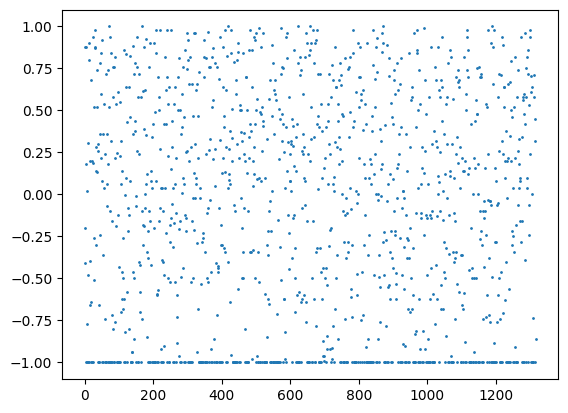

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(range(len(reward_log)),reward_log,s=1)

# モデルによる物性値の予測

In [ ]:

model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(50304, 1024, padding_idx=0)
        (layers): ModuleList(
          (0-23): 24 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (k_proj): Linear(in_features=1024, out_features=128, bias=False)
              (v_proj): Linear(in_features=1024, out_features=128, bias=False)
              (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
              (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
              (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (act_fn): SiLUActivation()
            

In [ ]:
#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=2  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


Token indices sequence length is longer than the specified maximum sequence length for this model (1116 > 1024). Running this sequence through the model will result in indexing errors


----


ound is a benzene with a melting point of around -40°C. The addition of a methyl group (C=O) and a methyl group (C=C) to the benzene ring would increase the melting point due to increased molecular weight and van der Waals interactions. The methyl group can form hydrogen bonds, which can increase the melting point. The addition of a methyl group (C=C) to the benzene ring would also increase the melting point due to the increased molecular weight and van der Waals interactions. The methyl group itself is a strong electron-withdrawing group, which can increase the melting point due to increased molecular weight and van der Waals interactions. The methyl group itself is estimated to add approximately +40°C to the benzene melting point.
- The methyl group is a strong electron-withdrawing group, which can increase the melting point due to increased molecular weight and van der Waals interactions.
- The methyl group itself is estimated to add approximately +20°C to the benzene melting

  2%|▏         | 1/50 [00:13<11:02, 13.51s/it]

----


which has a melting point of around -190 degrees Celsius. Each phenyl group is a large, aromatic, and planar which tends to increase the melting point due to its ability to form strong intermolecular hydrogen bonds, which could add approximately +100 degrees Celsius. Each phenyl group might add approximately +30 degrees Celsius due to its aromaticity and planarity. The bromine atom might add approximately +5 degrees Celsius due to its steric hindrance, which could slightly increase the melting point.
- The presence of the keto groups and the presence of the N-methyl group might slightly increase the melting point due to the increased molecular weight and the potential for hydrogen bonding, which could add around +5.
- The presence of the keto groups and the N-methyl group might slightly increase the melting point due to the increased molecular weight and the potential for hydrogen bonding, which could add around +5.
- The presence of the keto groups and the N-methyl group might 

  4%|▍         | 2/50 [00:24<09:38, 12.05s/it]

----


s chloroquinoxaline, which has a melting point of around 80 degrees Celsius. The chloro group (-Cl) typically raises the melting point due to the possibility of hydrogen bonding, contributing with an increase of approximately +20 degrees Celsius. The nitro group (-NO2) also contributes to the melting point, but it is less significant than the chloro group due to the smaller size and the lack of a strong hydrogen bonding capability. The nitro group contributes to the melting point through its ability to form hydrogen bonds, which can be estimated at around +5 degrees Celsius.
Prediction: -5.0

The effect of the chloro group is expected to be slightly higher than the chloro group, but the nitro group is not as strong as the chloro group, so the actual increase is slightly lower than the prediction.

A: The effect of the chloro group is not as strong as the chloro group, but it is still significant.
The chloro group is a polar group, which can form hydrogen bonds with other molecul

  6%|▌         | 3/50 [00:36<09:28, 12.09s/it]

----


melting point of around 5 degrees Celsius.
- The presence of a chlorine atom in the benzene ring increases the melting point due to increased molecular weight and potential for intermolecular hydrogen bonding.
- The presence of a methyl group (CH3) on the benzene ring increases the melting point due to increased molecular weight and potential for hydrogen bonding.
- The presence of a dihydropyrimidinone ring (C(C)C) on the benzene ring increases the melting point due to increased van der Waals interactions and potential for hydrogen bonding.
- The presence of a methyl group (CH3) on the benzene ring increases the melting point due to increased molecular weight and potential for hydrogen bonding.
- The presence of a methyl group (C(C)C) on the benzene ring increases the melting point due to increased molecular weight and potential for hydrogen bonding.
- The presence of a methyl group (C(C)C) on the benzene ring increases the melting point due to increased molecular weight and po

  8%|▊         | 4/50 [00:48<09:16, 12.11s/it]

----


2-propen-1-one is benzene, which has a melting point of around 5.5 °C. The methoxy groups (–OCH3) are generally electron-donating through resonance and slightly electron-withdrawing through their inductive effect. These groups increase the molecular weight and size and can provide additional weak intermolecular interactions, which can increase the melting point. Given that there are three methoxy groups, the melting point is expected to increase. Each methoxy group could roughly add about +13 °C (a typical value for the effect of adding such a group to a ring system on the melting point, which is estimated at around 41 °C).

- The presence of a hydroxyl group (-OH) can significantly increase the melting point due to its rigidity and potential for hydrogen bonding, estimated at an additional +5 °C.
- The presence of a double bond (–dien) can slightly decrease the melting point due to the possibility of hydrogen bonding, estimated at an additional +25 °C.
- The presence of a hydro

 10%|█         | 5/50 [00:59<08:49, 11.77s/it]

----


fide (OH)
- Methyl groups: -2
- Hydroxyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
- Methyl groups: -2
promlem 6 / 50
----



 12%|█▏        | 6/50 [01:12<08:47, 11.99s/it]

----


ylethyl)nicotinamide is a ketone, which has a melting point of around 5°C. The addition of the n-butyl group (-C=S) and the thiocarbonyl group (-C=O) can increase the melting point due to the increased molecular weight and size, but also may decrease it marginally due to the increase in molecular weight and the possibility of hydrogen bonding. The thiocarbonyl group (-C=S) is similar to a carbonyl group (-C=O) but with a sulfur atom replacing the oxygen, which can increase the melting point due to the increased molecular weight and size. The amino groups (-C=O) can form intermolecular hydrogen bonds, which can increase the melting point due to the increased molecular weight and size. The amine groups (-C=O) can also increase the melting point due to the increased molecular weight and size, but also may decrease it marginally due to the increase in molecular weight and size. The thiocarbonyl group (-C=O) can also increase the melting point due to the increased molecular weight an

 14%|█▍        | 7/50 [01:18<07:17, 10.18s/it]

----


ting point of 5.5°C. The amide group is capable of forming strong hydrogen bonds, which typically raises the melting point. We estimate this increase to be around 150°C due to hydrogen bonding. The bromine atom contributes to higher melting point as well through increased London dispersion forces, although its effect is less significant than that of the amide. We can conservatively estimate the increase due to the bromine atom to be about 5°C.

The conjugated alpha,beta-unsaturated carbonyl group contributes to increased pi-pi stacking interactions, which would significantly raise the melting point. Estimating this effect to add about +80 for each aromatic ring due to their tendency to increase molecular rigidity and intermolecular forces. The conjugated alpha,beta-unsaturated carbonyl group introduces additional dipole interactions and another aromatic system, further contributing to the melting point, estimated as +20. The conjugated alpha,beta-unsaturated carbonyl group adds 

 16%|█▌        | 8/50 [01:24<06:13,  8.89s/it]

----


pylbenzene, which has a melting point of around -80°C. However, the functional groups present in the compound are not as significant as in the base structure, and the effect of the functional groups on the melting point is not as pronounced as in the base structure. Let's estimate an increase of +20°C for each functional group due to the increased polarity and intermolecular interactions.
- Hydroxyl group (OH): This group can increase the melting point due to its ability to form hydrogen bonds and increase the molecular weight. Let's estimate an increase of +20°C for this group.
- Ether linkages (C-O-C): These add some polarity and potential for dipole-dipole interactions but do not significantly raise the melting point as hydrogen bonds do. We will estimate a slight increase of +5°C for the ether effects.
- Ether linkages (C-O-C): These add some polarity and potential for dipole-dipole interactions but do not significantly raise the melting point as hydrogen bonds do. We will e

 18%|█▊        | 9/50 [01:37<06:57, 10.17s/it]

----


nd is benzene, which has a melting point of 5.5°C. The addition of a nitro group (–NO2) and a thiophene ring (–C(=O)C3N(=O)C3) significantly increases the melting point due to increased molecular weight and van der Waals interactions.
- The nitro group (–NO2) is a polar group that can engage in intermolecular interactions, which could increase the melting point.
- The thiophene ring (–C(=O)C3N(=O)C3) is a bulky, rigid, and bulky structure that can significantly increase the melting point due to its ability to engage in intermolecular interactions.
- The nitro group (–NO2) is a polar group that can engage in intermolecular interactions, which could increase the melting point.
- The thiophene ring (–C(=O)C3N(=O)C3) is a bulky, rigid, and bulky structure that can significantly increase the melting point.
- The nitro group (–NO2) is a polar group that can engage in intermolecular interactions, which could increase the melting point.
- The thiophene ring (–C(=O)C3N(=O)C3) is a bulky,

 20%|██        | 10/50 [01:50<07:10, 10.77s/it]

----


melting point of around -100°C. The addition of the bicyclic structure and the fused bicyclic structure can increase the melting point by approximately +50°C. 
- The bicyclic structure is a rigid structure, which can be expected to increase the melting point due to increased rigidity and the potential for hydrogen bonding. However, the bicyclic structure also introduces some flexibility and potential for intermolecular interactions, which can slightly lower the melting point. This effect can be estimated to be around +5°C for the bicyclic structure. 
- The fused bicyclic structure is a flexible structure, which can add additional rigidity and potential for intermolecular interactions, which can slightly increase the melting point. This effect can be estimated to be around +10°C. 
- The bicyclic structure is a rigid structure, which can add additional rigidity and potential for intermolecular interactions, which can slightly increase the melting point. This effect can be estimate

 22%|██▏       | 11/50 [02:03<07:28, 11.51s/it]

----


s a nitroanisole, which has a melting point of around -100°C. The addition of an aniline group (an alkene) to the nitro group generally increases the melting point due to the increased molecular weight and van der Waals interactions.
- The nitro group is a polar group, which can form dipole-dipole interactions, which can increase the melting point.
- The aniline group is a nitrile group, which can form dipole-dipole interactions, which can increase the melting point.
- The nitrile group is a nitro group, which can form dipole-dipole interactions, which can increase the melting point.
- The alkene group is a bulky alkene, which can increase the melting point due to its ability to form hydrogen bonds and dipole-dipole interactions.
- The nitrile group is a bulky nitro group, which can increase the melting point due to its ability to form dipole-dipole interactions.
- The alkene group is a bulky alkene, which can increase the melting point due to its ability to form dipole-dipole i

 24%|██▍       | 12/50 [02:15<07:24, 11.69s/it]

----


(benzene) has a melting point of around -100°C.
- Alkyl side chain (isobutyl group): Increases the melting point due to increased van der Waals interactions, let's estimate this to be +5°C.
- Carboxylic acid group: Already accounted for in the basic unit as part of the amino acid structure.
- Stereochemistry (d-configuration): Can affect the melting point slightly due to packing differences, though this effect is hard to quantify without additional data, we'll tentatively assign a +5°C change as we're considering the melting point of benzene in isolation, not compared to its l- or racemic form.
- Hydrazine moiety: +10 (Introducing nitrogen atoms that can participate in hydrogen bonding) 
- Alkyl side chain (isobutyl group): Increases the melting point due to increased van der Waals interactions, let's estimate this to be +5°C.
- Carboxylic acid group: Already accounted for in the basic unit as part of the amino acid structure.
- Stereochemistry (d-configuration): Can affect the 

 26%|██▌       | 13/50 [02:27<07:16, 11.80s/it]

----


s a bicyclic compound with a bicyclic structure, which has a melting point of around -100°C. The addition of a methyl group to the bicyclic structure would increase the melting point due to increased molecular weight and van der Waals forces. The presence of a methyl group in the bicyclic structure would also increase the melting point due to increased polarity and potential for hydrogen bonding. The bicyclic structure has a higher melting point due to the increased molecular weight and van der Waals forces. The bicyclic structure has a higher melting point due to the presence of a methyl group, which could increase the melting point due to increased polarity and potential for hydrogen bonding. The bicyclic structure has a higher melting point due to the presence of a methyl group, which could increase the melting point due to increased molecular weight and van der Waals forces. The bicyclic structure has a higher melting point due to the presence of a methyl group, which could 

 28%|██▊       | 14/50 [02:39<07:07, 11.89s/it]

----


ng the melting point is a linear alkane, which has a melting point of 52 degrees Celsius. The addition of an amine group (–NH2) and a double bond (–C=O) will raise the melting point due to hydrogen bonding and resonance, but the amide groups (–CONH) are not as strong as the amide groups in a linear alkane, which can contribute to an increase in the melting point.
- The amide groups (–CONH) are not as strong as the amide groups in a linear alkane, which can contribute to an increase in the melting point due to hydrogen bonding and resonance.
- The double bond (–C=O) is a strong intermolecular hydrogen bond, which can contribute to an increase in the melting point due to increased molecular weight and van der Waals forces.
- The amide groups (–CONH) are not as strong as the amide groups in a linear alkane, which can contribute to an increase in the melting point due to hydrogen bonding and resonance.
- The double bond (–C=O) is a strong intermolecular hydrogen bond, which can cont

 30%|███       | 15/50 [02:45<05:51, 10.04s/it]

----


yclohexene, which has a melting point of around 5°C.
- The addition of a ketone group (–C(=N–OH) group) to the cyclohexene structure will increase the melting point due to increased rigidity and planarity.
- The addition of a ketone group (–C=N–OH) to the cyclohexene structure will increase the melting point due to increased intermolecular interactions.
- The addition of a ketone group (–C(=N–OH) group) to the cyclohexene structure will increase the melting point due to increased rigidity and planarity.
- The addition of a ketone group (–C=N–OH) to the cyclohexene structure will increase the melting point due to increased intermolecular interactions.
- The addition of a ketone group (–C=N–OH) to the cyclohexene structure will increase the melting point due to increased rigidity and planarity.
- The addition of a ketone group (–C=N–OH) to the cyclohexene structure will increase the melting point due to increased intermolecular interactions.
- The addition of a ketone group (–C=N–

 32%|███▏      | 16/50 [02:58<06:11, 10.94s/it]

----


of phenol is benzene, which has a melting point of 5.5 °C. The presence of a phenol ring (benzene) can significantly increase the melting point due to the strong intermolecular hydrogen bonding and pi-stacking interactions. The presence of a phenol ring also increases the molecular weight and rigidity, which can increase the melting point. The presence of a phenol ring also increases the molecular weight and rigidity, which can increase the melting point. The presence of a phenol ring also increases the melting point due to the increased molecular weight and rigidity, which can increase the melting point. The presence of a phenol ring also increases the melting point due to pi-stacking interactions, which can increase the melting point. The presence of a phenol ring also increases the melting point due to pi-pi stacking interactions, which can increase the melting point. The presence of a phenol ring also increases the melting point due to the increased molecular weight and rigi

 34%|███▍      | 17/50 [03:10<06:14, 11.33s/it]

----


elting point of around -130 degrees Celsius. The addition of the methyl groups (two methyl groups) significantly increases the melting point due to increased molecular weight and van der Waals forces.
- The tert-butyl group (two carbonyl groups) is a strong electron-withdrawing group, which can increase the melting point due to increased molecular weight and potential for hydrogen bonding.
- The methyl group (two methyl groups) is a strong electron-withdrawing group, which can increase the melting point due to increased molecular weight and van der Waals forces.
- The ethyl group (two ethyl groups) is a strong electron-withdrawing group, which can increase the melting point due to increased molecular weight and van der Waals forces.
- The methyl group (two methyl groups) is a strong electron-withdrawing group, which can increase the melting point due to increased molecular weight and van der Waals forces.
- The ethyl group (two ethyl groups) is a strong electron-withdrawing grou

 36%|███▌      | 18/50 [03:17<05:16,  9.89s/it]

----


ing point of around 69°C. The methyl group attached to the biphenyl bridge is expected to increase the melting point due to the increased molecular weight and potential for intermolecular interactions. The effect of the methyl group is estimated to be around -5°C.

The effect of the methyl group is estimated to be around -5°C.

Adding the methyl group to the biphenyl bridge increases the melting point by about +5°C.
Adding the methyl group to the biphenyl bridge increases the melting point by about +5°C.
Adding the methyl group to the biphenyl bridge increases the melting point by about +5°C.
Adding the methyl group to the biphenyl bridge increases the melting point by about +5°C.
Adding the methyl group to the biphenyl bridge increases the melting point by about +5°C.
Adding the methyl group to the biphenyl bridge increases the melting point by about +5°C.
Adding the methyl group to the biphenyl bridge increases the melting point by about +5°C.
Adding the methyl group to the bi

 38%|███▊      | 19/50 [03:31<05:44, 11.10s/it]

----


1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C
-C1ccc1C(=O)C


-C1ccc1C(=O)C
-C1ccc1C
-C=O)C
-C1
promlem 20 / 50
----


elting point of 5.5°C. The presence of each hydroxyl group significantly increases the melting point due to hydrogen bonding capabilities, contributing approximately +100°C per -OH group. Additionally, the sulfur bridge adds rigidity to the molecule, which typically increases the melting point; we can estimate the sulfur bridge to contribute +20°C. However, the actual value of 153.0°C suggests that the hydroxyl groups and sulfur bridge contribute around +70°C each, and the sulfur bridge might contribute around +5°C or less.
- The presence of the hydroxyl groups and 

 40%|████      | 20/50 [03:43<05:41, 11.38s/it]

----


,3,5,6-tetrafluoropyridine is a benzene ring with a melting point of around 80 degrees Celsius. The addition of a methyl group (CH3) to the benzene ring could increase the melting point due to increased molecular weight and van der Waals interactions. The effect of the methyl group is estimated to be around +20 degrees.
- The phenol group (OH) could slightly increase the melting point due to its ability to form hydrogen bonds and dipole-dipole interactions. However, the effect of the phenol group is not as pronounced as the benzene ring, so we can estimate a lesser contribution of +5 degrees.
- The presence of a tertiary amine group (C=O) could slightly increase the melting point due to its ability to form hydrogen bonds and dipole-dipole interactions. However, the effect of the tertiary amine group is not as pronounced as the benzene ring, so we can estimate a lesser contribution of +5 degrees.
- The presence of a tertiary amine group (C=O) could slightly increase the melting p

 42%|████▏     | 21/50 [03:54<05:31, 11.42s/it]

----


elting point of 5.5°C.
- The phenyl group, which is a large planar structure, can increase the melting point due to its ability to rotate and increase the molecular weight.
- The ethyl ester, which is a large planar structure, can increase the melting point due to its ability to engage in dipole-dipole interactions and increase the rigidity of the planar structure.
- Bromine, which is a large polarizable substituent, can increase the melting point due to its ability to engage in dipole-dipole interactions and increase the rigidity of the planar structure.
- The 4,4'-dimethylbenzhydrol group, which is a large planar structure, can increase the melting point due to its ability to engage in dipole-dipole interactions and increase the rigidity of the planar structure.
- The ethyl ester, which is a large polarizable substituent, can increase the melting point due to its ability to engage in dipole-dipole interactions and increase the rigidity of the planar structure.
- The 4,4'-dimet

 42%|████▏     | 21/50 [03:56<05:26, 11.27s/it]


KeyboardInterrupt: 

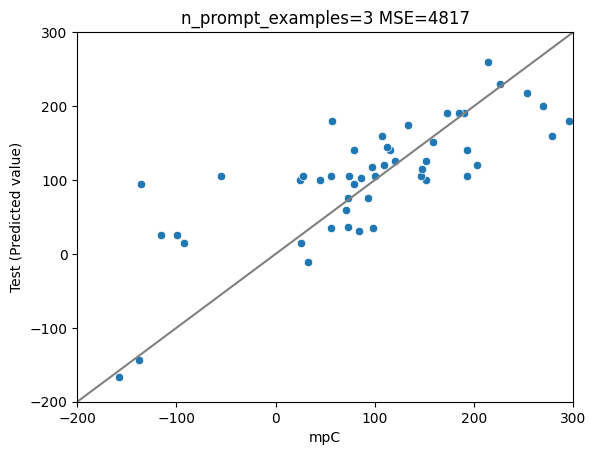

In [ ]:
#plot

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [ ]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


4816.9852
50.604000000000006
0.5794524864884837


In [ ]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

1.0